In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score, accuracy_score, roc_auc_score

# EDA

In [3]:
df = pd.read_csv(r'', header=0) #write path to file
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
df = df.drop(columns=['id', 'name', 'host_id', 'host_name'])
df = df.fillna(0)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Is there any noticeable difference of traffic among different areas?

Firstly, it is necessary to consider the dependence of the price and type of room on location:

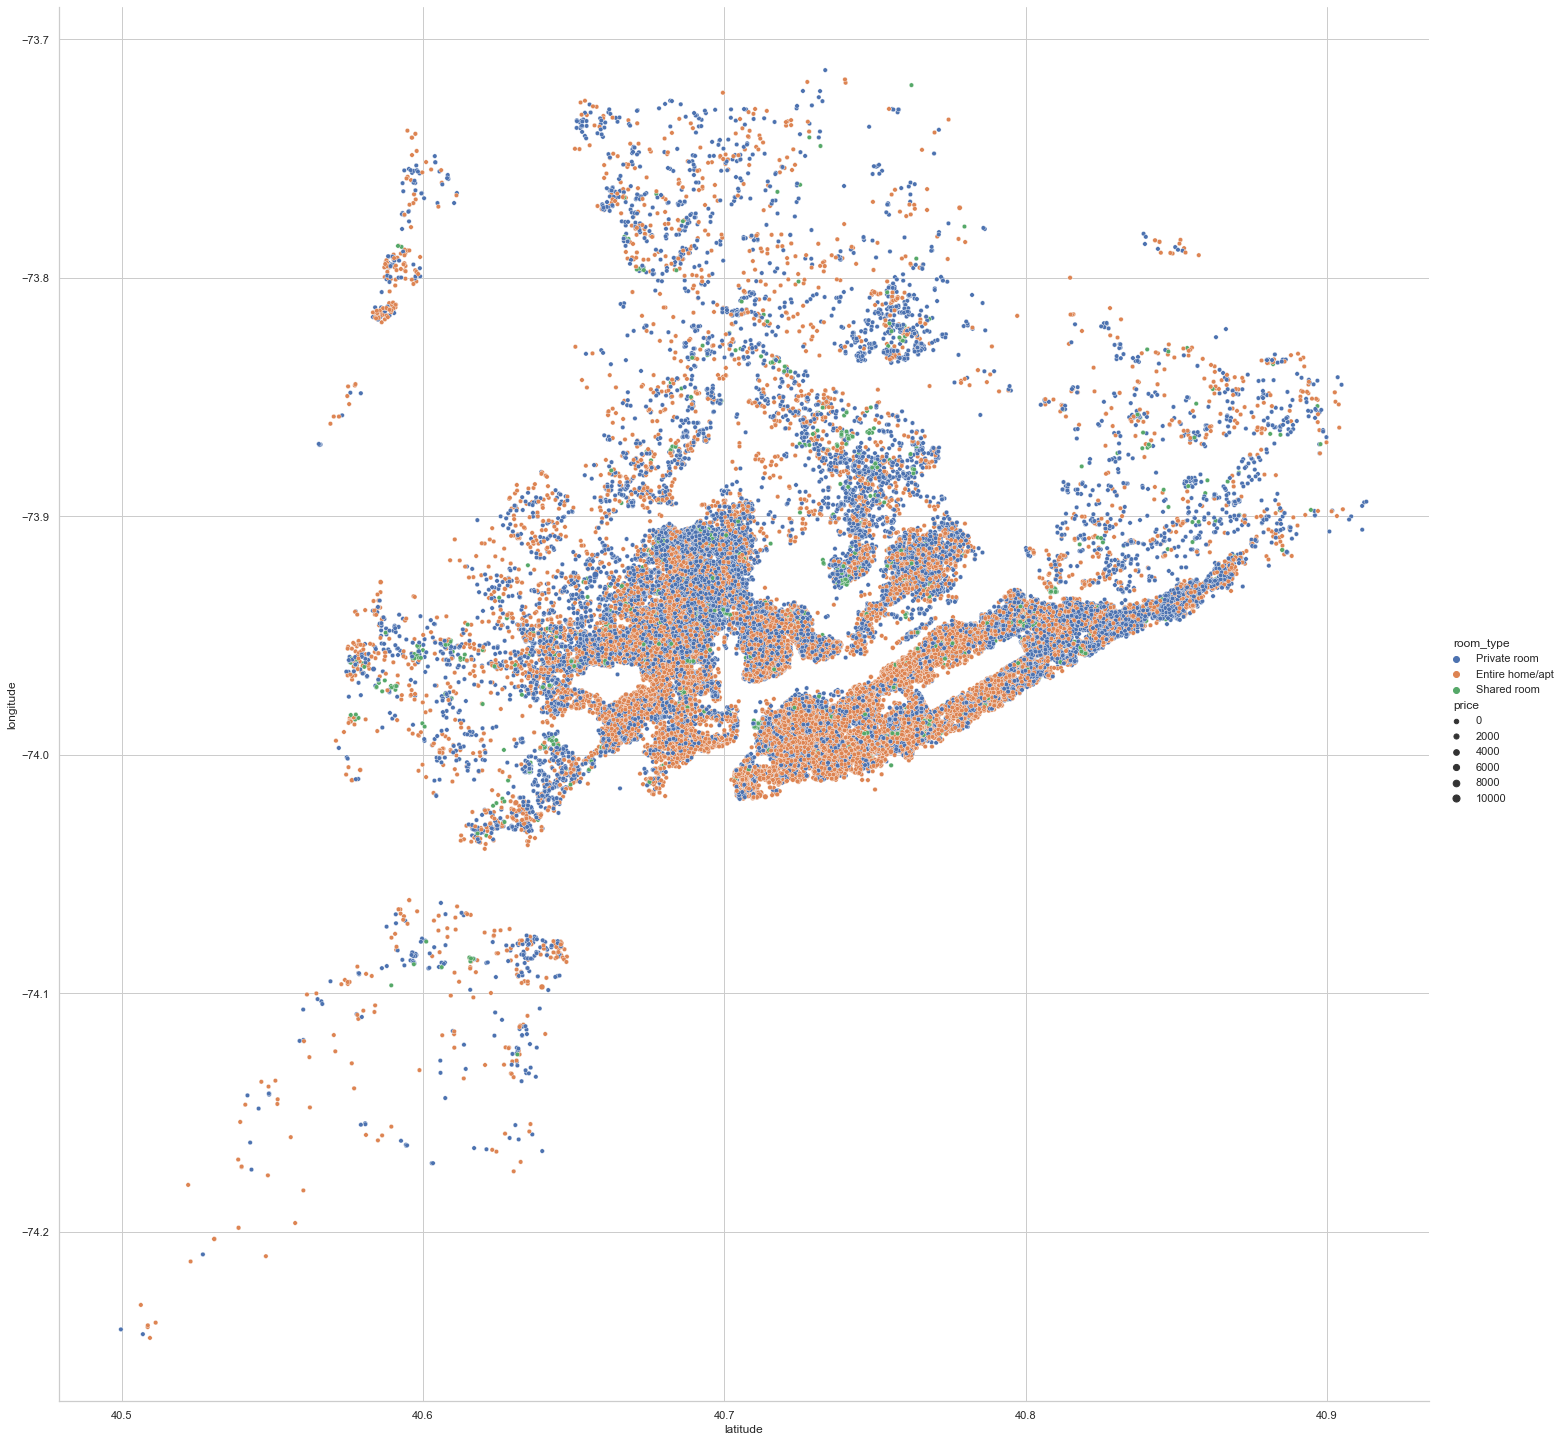

In [5]:
sns.set_theme(style='whitegrid')
sns.relplot(data=df, x='latitude', y='longitude', hue='room_type', size='price', sizes=(20, 50), height=20)

On the map the range of prices is quite narrow. It is worth evaluating the distribution:

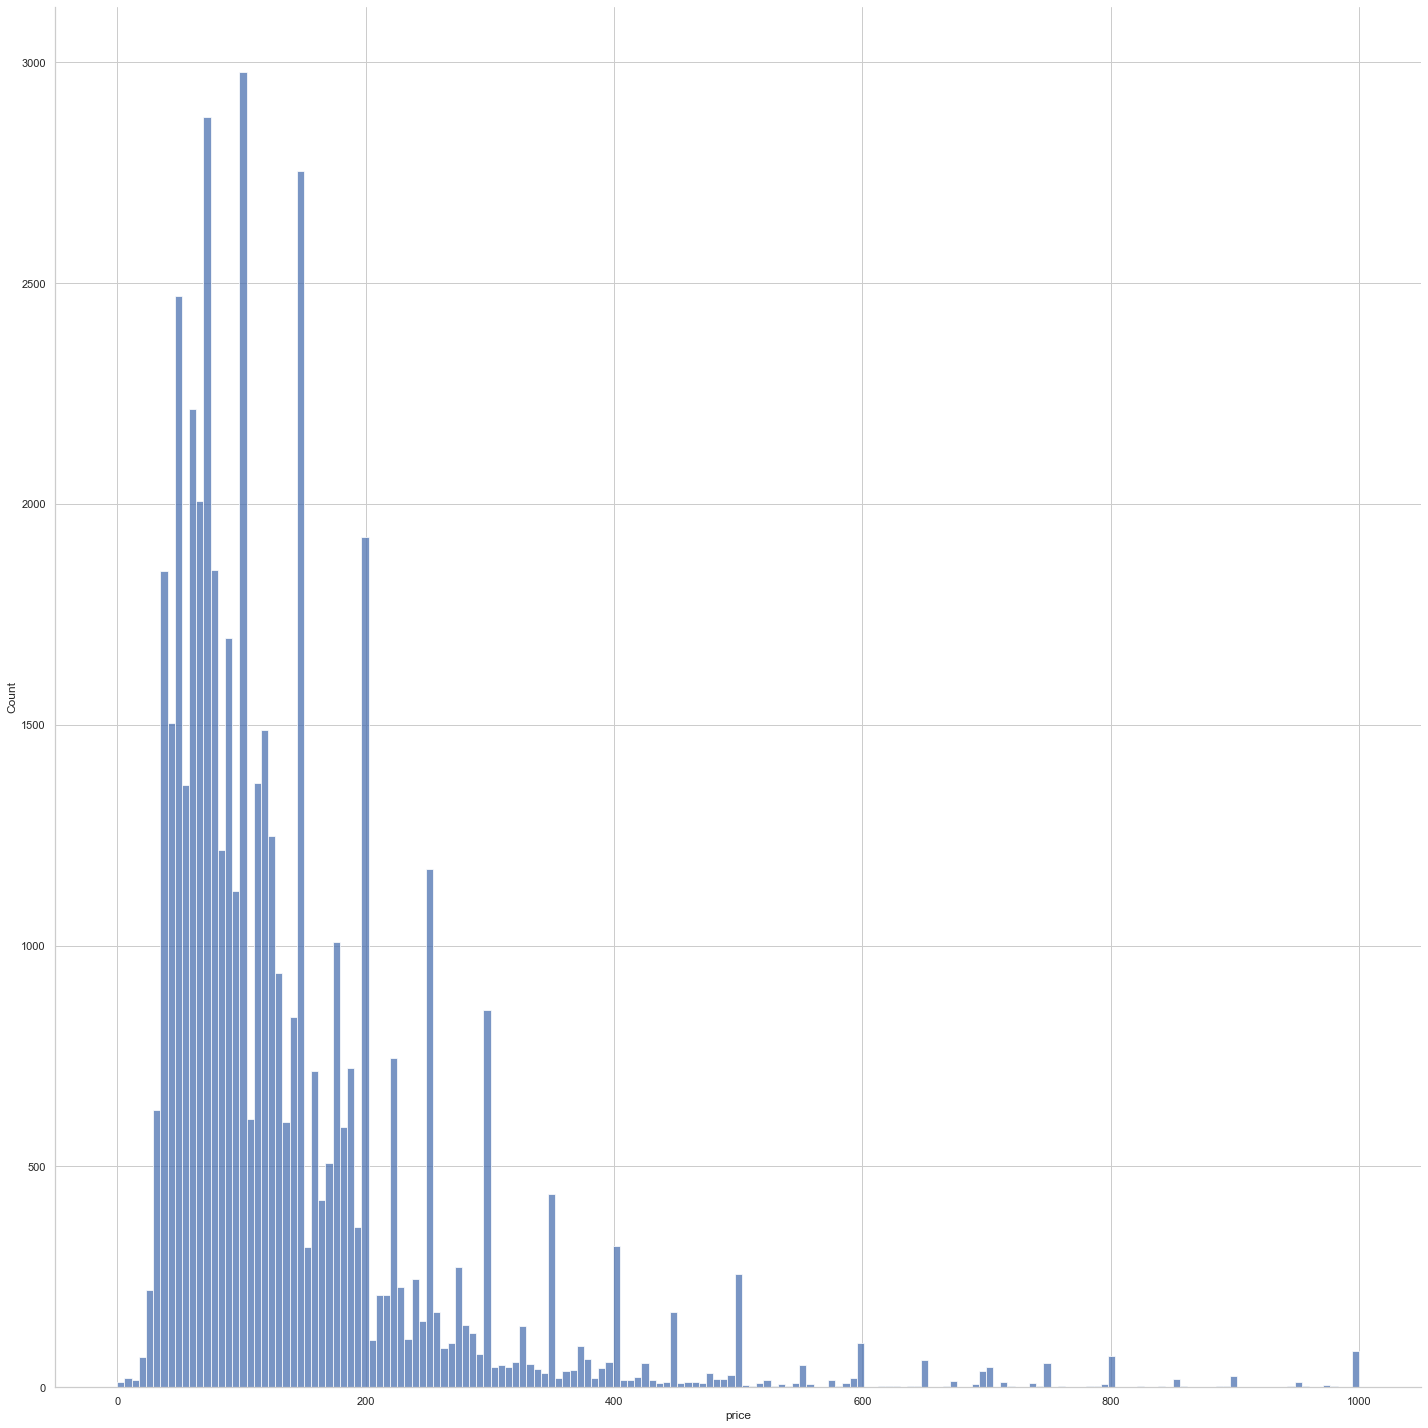

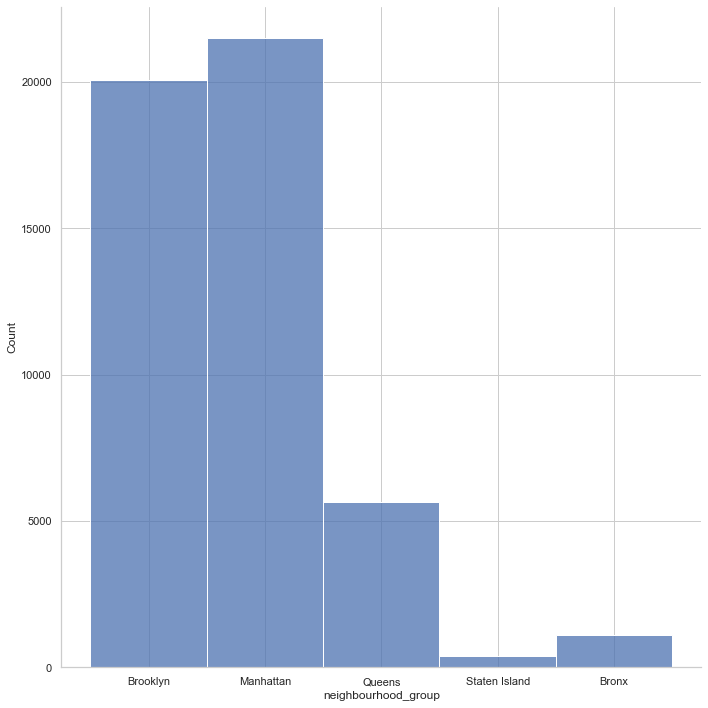

In [6]:
sns.displot(data=df.loc[df['price'] <= 1000], x='price', height=20)
sns.displot(data=df.loc[df['price'] <= 1000], x='neighbourhood_group', height=10)

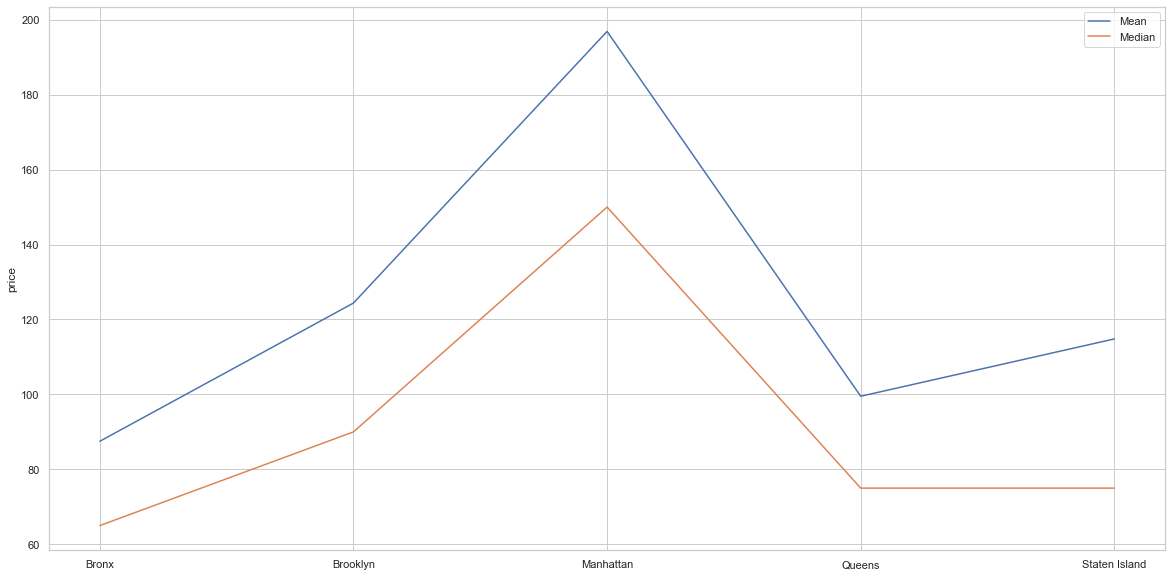

In [7]:
mean = []
median = []
boro = np.unique(df[['neighbourhood_group']])
for a in boro:
    mean.append(np.mean(df.loc[df['neighbourhood_group'] == a, 'price']))
    median.append(np.median(df.loc[df['neighbourhood_group'] == a, 'price']))
fig, ax = plt.subplots()
ax.plot(range(1, 6), mean, label='Mean')
ax.plot(range(1, 6), median, label='Median')
plt.xticks(range(1, 6), boro)
fig.set_figwidth(20)
fig.set_figheight(10)
ax.set_ylabel('price')
ax.legend()
plt.show() 

The price range is within 0-325. The price depends on the area, correlates with host count.

About the price indicator relative to the room_type:

Counts:  45.661110543000305 % private room /  51.96645873811229 % entire home-apt /  2.372430718887412 % shared room


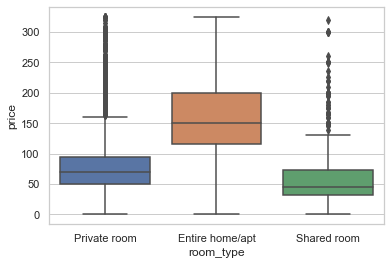

In [8]:
sns.boxplot(data=df.loc[df['price'] <= 325], x='room_type', y='price')
all_sum = df.index.size
pr_sum = df.loc[df['room_type'] == 'Private room']
pr_sum = pr_sum.index.size/all_sum*100
er_sum = df.loc[df['room_type'] == 'Entire home/apt']
er_sum = er_sum.index.size/all_sum*100
sr_sum = df.loc[df['room_type'] == 'Shared room']
sr_sum = sr_sum.index.size/all_sum*100
print('Counts: ', pr_sum, '% private room / ', er_sum, '% entire home-apt / ', sr_sum, '% shared room')

Considering all the above, the some connection between price and area should be accepted.

Need to establish the relationship between numerical signs.

Here is Correlation map:

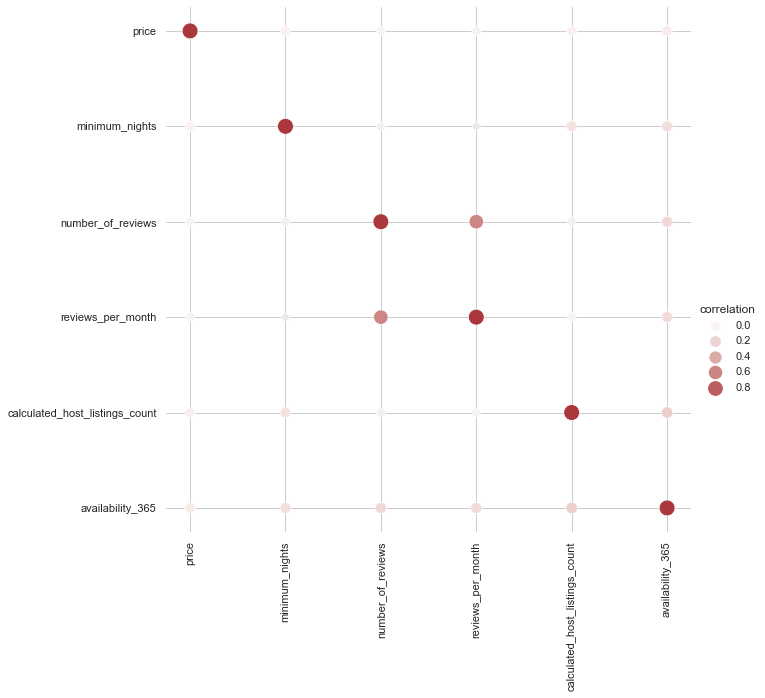

In [9]:
f = df[['price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
map_ = f.corr().stack().reset_index(name='correlation')
g = sns.relplot(data=map_, x='level_0', y='level_1', hue='correlation', size='correlation',
            palette='vlag', hue_norm=(-1, 1), edgecolor='1',
            height=10, sizes=(50, 250), size_norm=(-.2, .8),)
g.set(xlabel='', ylabel='', aspect='equal')
g.despine(left=True, bottom=True)
g.ax.margins(.05)

for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor('1')

<AxesSubplot:xlabel='availability_365', ylabel='neighbourhood_group'>

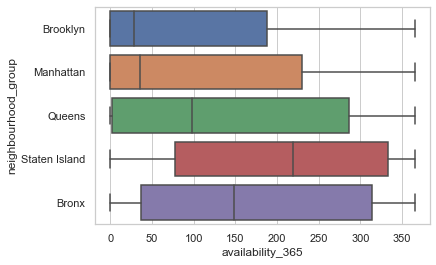

In [10]:
sns.boxplot(data=df[['neighbourhood_group', 'availability_365']], 
             x='availability_365', y='neighbourhood_group')

<AxesSubplot:xlabel='reviews_per_month', ylabel='neighbourhood_group'>

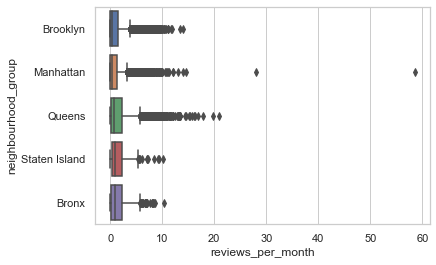

In [11]:
sns.boxplot(data=df[['neighbourhood_group', 'reviews_per_month']], 
             x='reviews_per_month', y='neighbourhood_group')

Values after 6 in all samples are outliers.

<AxesSubplot:xlabel='reviews_per_month', ylabel='neighbourhood_group'>

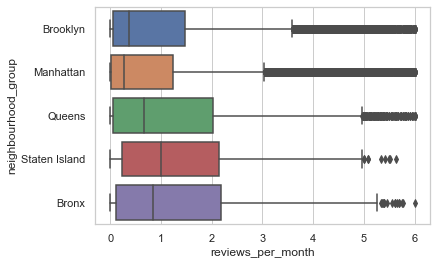

In [12]:
df_fl = df.loc[df['reviews_per_month'] <= 6]
sns.boxplot(data=df_fl[['neighbourhood_group', 'reviews_per_month']], 
             x='reviews_per_month', y='neighbourhood_group')

The spread of averages should be presented in a different form.

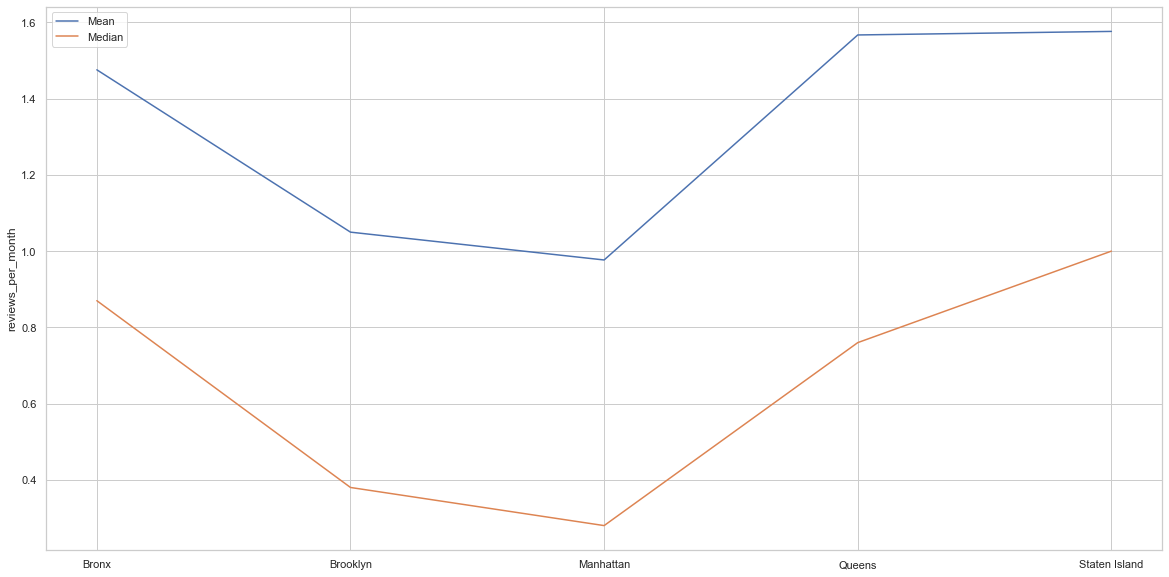

In [13]:
mean = []
median = []
boro = np.unique(df[['neighbourhood_group']])
for a in boro:
    mean.append(np.mean(df.loc[df['neighbourhood_group'] == a, 'reviews_per_month']))
    median.append(np.median(df.loc[df['neighbourhood_group'] == a, 'reviews_per_month']))
fig, ax = plt.subplots()
ax.plot(range(1, 6), mean, label='Mean')
ax.plot(range(1, 6), median, label='Median')
plt.xticks(range(1, 6), boro)
fig.set_figwidth(20)
fig.set_figheight(10)
ax.set_ylabel('reviews_per_month')
ax.legend()
plt.show()    

The value is non-linear. It is worth repeating this with a set of counties.

In [14]:
len(np.unique(df[['neighbourhood']])) #need pairplot

221

Amount of Bronx is 48
Amount of Brooklyn is 47
Amount of Manhattan is 32
Amount of Queens is 51
Amount of Staten Island is 43


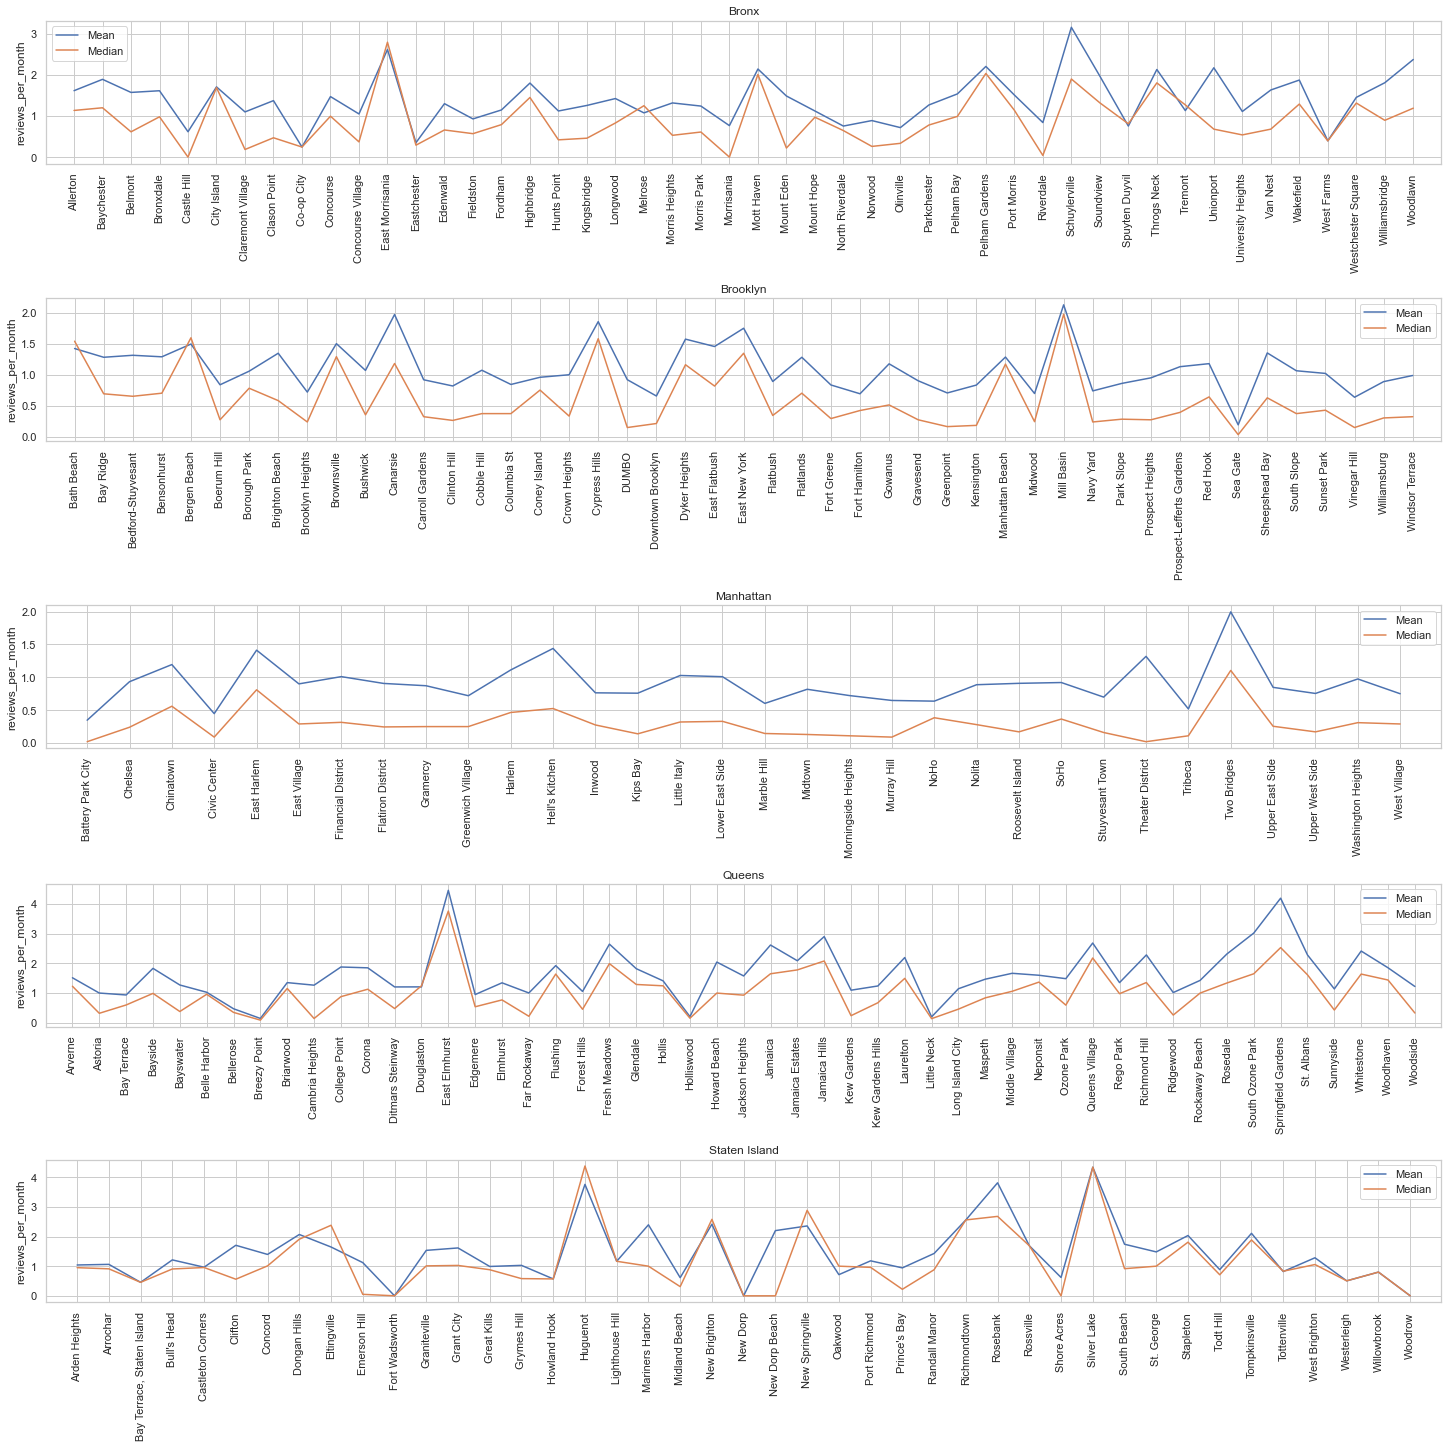

In [15]:
def makingData(boro):
    mean = []
    median = []
    ticks = np.unique(df.loc[df['neighbourhood_group'] == boro, 'neighbourhood'])
    for a in ticks:
        mean.append(np.mean(df.loc[df['neighbourhood'] == a, 'reviews_per_month']))
        median.append(np.median(df.loc[df['neighbourhood'] == a, 'reviews_per_month']))
    return mean, median, ticks

fig, axs = plt.subplots(5, 1, constrained_layout=True)
for i, v in enumerate(boro):
    mean, median, ticks = makingData(v)
    print('Amount of %s is %s' % (v, len(ticks)))
    axs[i].plot(range(len(ticks)), mean, label='Mean')
    axs[i].plot(range(len(ticks)), median, label='Median')
    axs[i].set_title(v)
    axs[i].set_xticks(range(len(ticks)))
    axs[i].set_xticklabels(ticks)
    axs[i].set_xmargin(1/len(ticks))
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_ylabel('reviews_per_month')
    axs[i].legend()
    
fig.set_figwidth(20)
fig.set_figheight(20)
plt.show()  

Finally, let's look at the relationship between price and reviews_per_month.

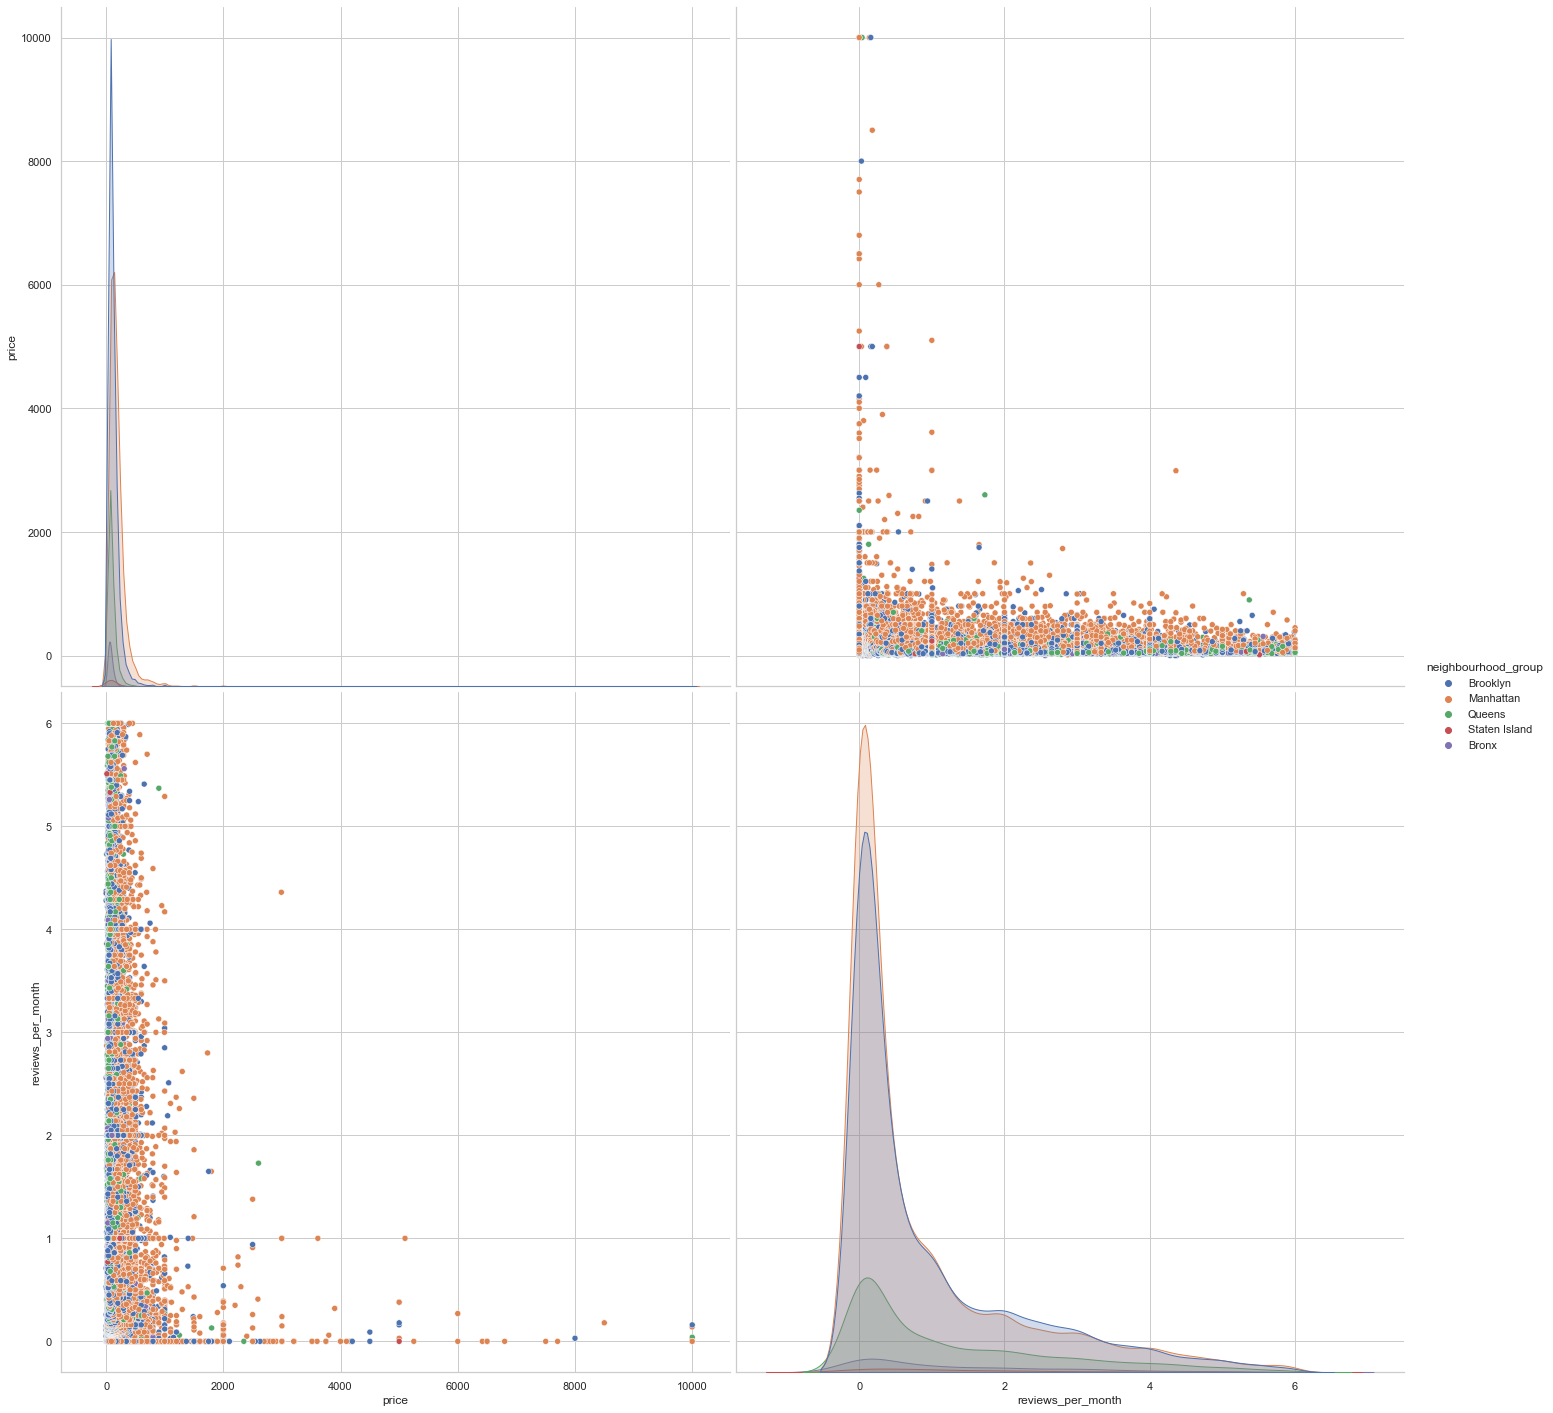

In [16]:
sns.pairplot(data=df_fl[['neighbourhood_group', 'price', 'reviews_per_month']], hue='neighbourhood_group', height=10)

# Model prediction of Boro

Area and coordinates are not included.

Preprocessing of dataset:

In [17]:
df_fl = df.loc[(df.all()['reviews_per_month'] <= 6) and\
               (df['price'] <= 2000)]

In [18]:
classlabels = {label:ids for ids, label in enumerate(np.unique(df_fl['neighbourhood_group']))}#labels encoding
df_fl['neighbourhood_group'] = df_fl['neighbourhood_group'].map(classlabels)
roomlabels = {label:ids for ids, label in enumerate(np.unique(df_fl['room_type']))}
df_fl['room_type'] = df_fl['room_type'].map(roomlabels)
print(df_fl)
print(classlabels)
print(roomlabels)

       neighbourhood_group       neighbourhood  latitude  longitude  \
0                        1          Kensington  40.64749  -73.97237   
1                        2             Midtown  40.75362  -73.98377   
2                        2              Harlem  40.80902  -73.94190   
3                        1        Clinton Hill  40.68514  -73.95976   
4                        2         East Harlem  40.79851  -73.94399   
...                    ...                 ...       ...        ...   
48890                    1  Bedford-Stuyvesant  40.67853  -73.94995   
48891                    1            Bushwick  40.70184  -73.93317   
48892                    2              Harlem  40.81475  -73.94867   
48893                    2      Hell's Kitchen  40.75751  -73.99112   
48894                    2      Hell's Kitchen  40.76404  -73.98933   

       room_type  price  minimum_nights  number_of_reviews last_review  \
0              1    149               1                  9  2018-10-19   

C:\Users\VezoR\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\VezoR\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
df_fl = df_fl[['neighbourhood_group', 
               'room_type',
               'number_of_reviews', 
               'reviews_per_month',
               'availability_365',
               'price']]

Making the split and testing:

In [20]:
y = df_fl['neighbourhood_group']
x = df_fl.drop(columns='neighbourhood_group')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
np.array(y_train)
print(len(x_train), len(x_test), len(y_train), len(y_test))

39047 9762 39047 9762


C:\Users\VezoR\anaconda3\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of LogisticRegression() is 0.51
Accuracy of XGBClassifier(objective='multi:softprob') is 0.57
Accuracy of MLPClassifier() is 0.49
Accuracy of RandomForestClassifier() is 0.54
Accuracy of AdaBoostClassifier() is 0.55


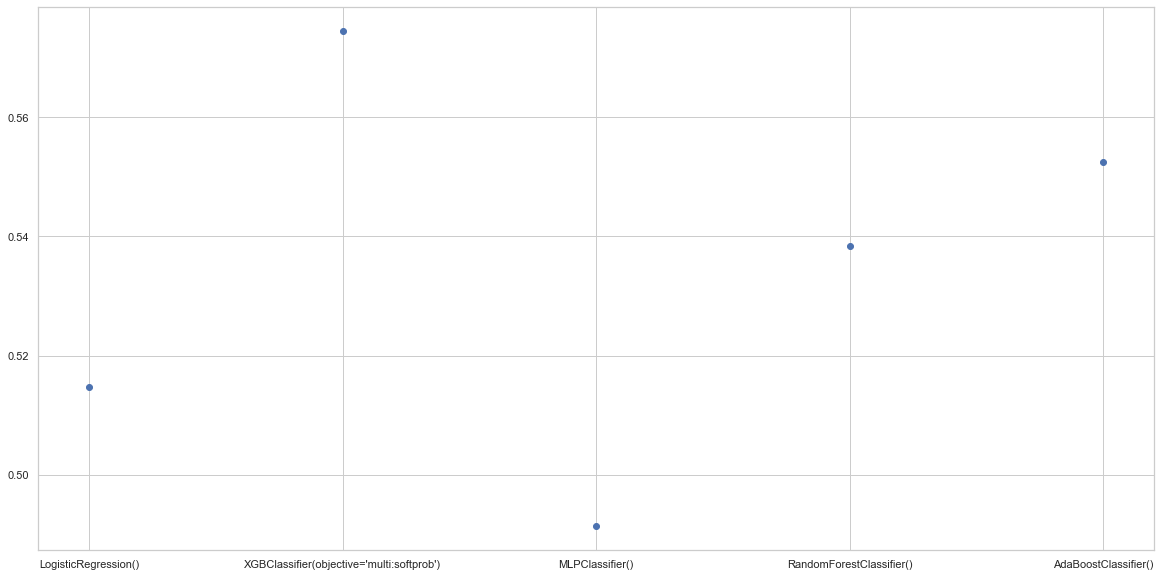

In [21]:
classifiers = [LogisticRegression(), XGBClassifier(), MLPClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
accs = []
fig, ax = plt.subplots()
for cls in classifiers:
    cls.fit(x_train, y_train)
    y_pred = cls.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    print('Accuracy of %s is %s' % (str(cls), round(acc, 2)))
    
ax.scatter(range(len(accs)), accs)
plt.xticks(range(len(accs)), [str(s) for s in classifiers])
fig.set_figwidth(20)
fig.set_figheight(10)
plt.show()

Obviously, the standard XGBClassifier has the best rating.
Now tune its hyperparameters with CV.

In [22]:
est = XGBClassifier(random_state=0)

In [23]:
gs = GridSearchCV(estimator=est, 
                  param_grid=[{'booster': ['gbtree'],
                           'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
                           'max_depth': [0, 1, 2, 3, 4, 5]}],
                  scoring='f1_weighted',
                  n_jobs=-1,
                  cv=5,
                  verbose=2)
gs.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.0min finished


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid=[{'booster': ['gbtree'],
                          'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'max_depth': [0, 1, 2, 3, 4, 5]}],
             scoring='f1_weighted', verbose=2)

In [24]:
y_pred = gs.predict(x_test)

[[   6  174   35    6    0]
 [   1 2506 1455   25    0]
 [   0 1282 3030   10    0]
 [   1  844  263   61    1]
 [   1   44   14    3    0]]


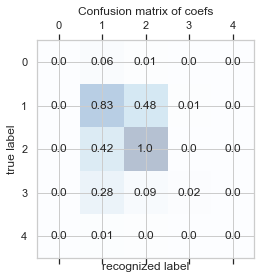

In [25]:
cmatrix = confusion_matrix(y_test, y_pred)
print(cmatrix)
fig, ax = plt.subplots()
ax.matshow(cmatrix, cmap=plt.cm.Blues, alpha=0.3)
best_v = cmatrix.max()
for i in range(cmatrix.shape[0]):
    for j in range(cmatrix.shape[1]):
        ax.text(x=j, y=i, s=round(cmatrix[i, j]/best_v, 2), va='center', ha='center')
plt.xlabel('recognized label')
plt.ylabel('true label')
plt.title('Confusion matrix of coefs')
plt.show()

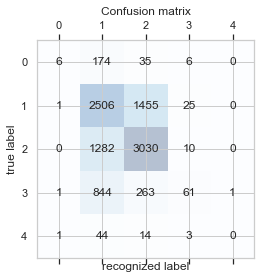

In [26]:
fig, ax = plt.subplots()
ax.matshow(cmatrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cmatrix.shape[0]):
    for j in range(cmatrix.shape[1]):
        ax.text(x=j, y=i, s=cmatrix[i, j], va='center', ha='center')
plt.xlabel('recognized label')
plt.ylabel('true label')
plt.title('Confusion matrix')
plt.show()

In [27]:
print('Recall is %s; F1 is %s; Precision is %s; Accuracy is %s' %
      (round(recall_score(y_test, y_pred, average='weighted'), 3), #average weighted by support
       round(f1_score(y_test, y_pred, average='weighted'), 3), 
       round(precision_score(y_test, y_pred, average='weighted'), 3),
       round(accuracy_score(y_test, y_pred), 3)))

Recall is 0.574; F1 is 0.539; Precision is 0.575; Accuracy is 0.574
